# Yet another EDA Notebook

In [369]:
from ultralytics import YOLO

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2

import numpy as np

from PIL import Image

In [474]:
image_path = '../../data/roboflow/Basketball Players.v22-raw-images-scoreboardclassesonly-nonulls.yolov8/test/images/youtube-0_jpg.rf.0c58f13a69f202f67cb5eef3c9360c92.jpg'
image_path_2 = '../../data/roboflow/Basketball Players.v22-raw-images-scoreboardclassesonly-nonulls.yolov8/test/images/youtube-29_jpg.rf.27209b1328f706fa398f0f13d25d22c2.jpg'

model_path = '../../data/example_court_2.jpg'

In [478]:
image = plt.imread(image_path)
image2 = plt.imread(image_path_2)

model = cv2.imread(model_path, cv2.IMREAD_GRAYSCALE)

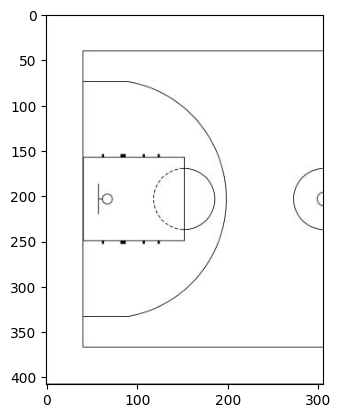

In [479]:
height, width = model.shape
middle = width // 2
model = model[:, :middle]
plt.imshow(Image.fromarray(model), cmap='gray')

## Court Detection

### Approach 1: Naive CV2 Approach

Here we do filtering and contour detection and try to identify rectangular portions.

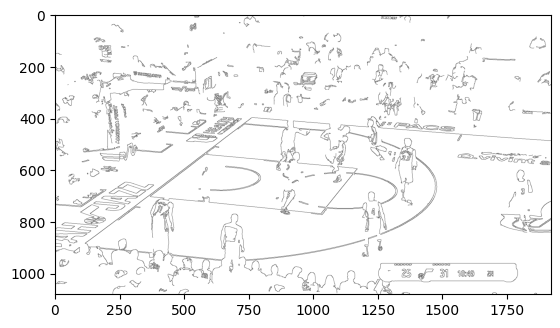

In [480]:
edges = cv2.bitwise_not(cv2.Canny(image2, 600, 100))
plt.imshow(Image.fromarray(edges), cmap='gray')

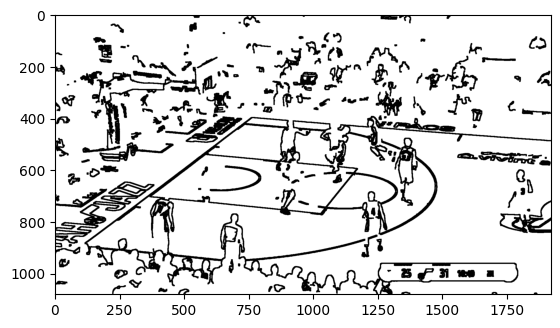

In [481]:
kernel = np.ones((5, 5), np.uint8)
edges = cv2.erode(edges, kernel, iterations=1)
plt.imshow(Image.fromarray(edges), cmap='gray')

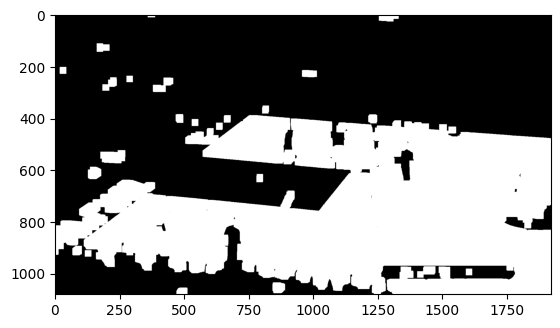

In [482]:
lower = np.uint8([0, 170, 0])
upper = np.uint8([255, 255, 255])
white_mask = cv2.inRange(image2, lower, upper)
# yellow color mask
lower = np.uint8([0, 0,   100])
upper = np.uint8([40, 255, 255])
yellow_mask = cv2.inRange(image2, lower, upper)
# combine the mask
mask = cv2.bitwise_or(white_mask, yellow_mask)
result = image2.copy()

kernel = np.ones((5, 5), np.uint8)
mask = cv2.erode(mask, kernel, iterations=1)  
mask = cv2.dilate(mask, kernel, iterations=6)

plt.imshow(Image.fromarray(mask), cmap='gray')

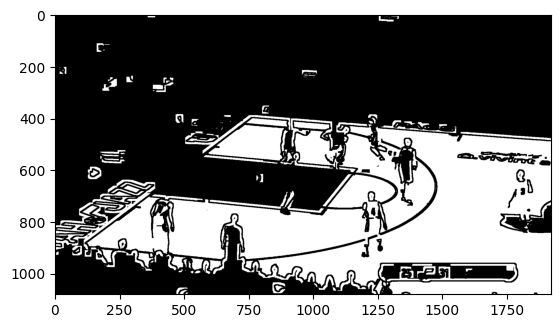

In [483]:
filtered = cv2.bitwise_and(mask, edges)
plt.imshow(Image.fromarray(filtered), cmap='gray')

In [484]:
imgray = cv2.blur(filtered.copy(), (3,3))
ret, thresh = cv2.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = [ x for x in contours if (len(x) >= 2 and dist(x[0][0], x[-1][0]) > 150) ]

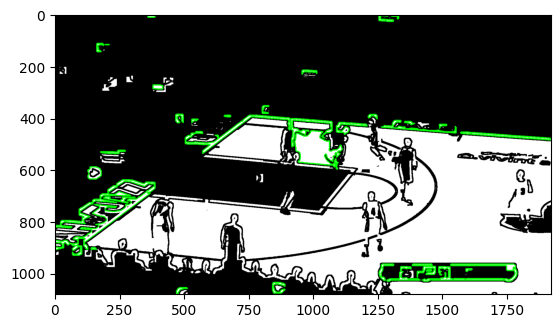

In [485]:
res = cv2.drawContours(cv2.cvtColor(filtered, cv2.COLOR_GRAY2RGB), contours, -1, (0,255,0), 3)
plt.imshow(Image.fromarray(res))

In [486]:
orb_detector = cv2.ORB_create(5000)
kp1, d1 = orb_detector.detectAndCompute(filtered, None)
kp2, d2 = orb_detector.detectAndCompute(model, None)
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)
matches = matcher.match(d1, d2)

In [487]:
# Initialize SIFT or ORB detector
# sift = cv2.SIFT_create()  # For SIFT
orb = cv2.ORB_create()  # For ORB

# Find the keypoints and descriptors with SIFT or ORB
keypoints1, descriptors1 = orb.detectAndCompute(filtered, None)
keypoints2, descriptors2 = orb.detectAndCompute(model, None)

# Create BFMatcher and match descriptors
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# Apply ratio test to find good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Extract location of good matches
points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])

In [488]:
imgray = filtered.copy()
ret, thresh = cv2.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [489]:
points1

array([[     943.49,      1010.9]], dtype=float32)

In [490]:
homography, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

error: OpenCV(4.8.1) /Users/xperience/GHA-OpenCV-Python/_work/opencv-python/opencv-python/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'


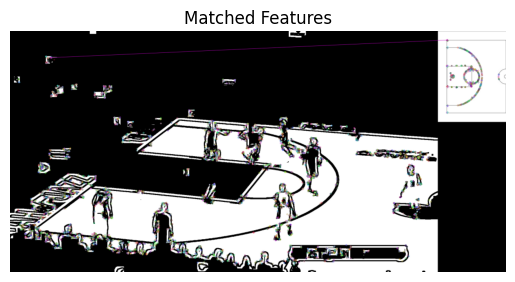

In [491]:
import imutils

# Correcting the size argument in warpPerspective
transformed_img = cv2.warpPerspective(filtered, homography, (model.shape[1], model.shape[0]))

# Converting good matches for drawMatches
good_matches_to_draw = [cv2.DMatch(_queryIdx=i, _trainIdx=i, _distance=0) for i in range(len(good_matches))]

# Using drawMatches to visualize matches
matchedVis = cv2.drawMatches(filtered, kp1, model, kp2, good_matches_to_draw, None)

# Resize for better viewing
matchedVis = imutils.resize(matchedVis, width=1000)

# Display the image
plt.imshow(matchedVis)
plt.title('Matched Features')
plt.axis('off')  # Hide axis
plt.show()

In [492]:
def match_images_cv2(img1, img2): # return img1 warped to be like img2
    # Initialize SIFT or ORB detector
    # sift = cv2.SIFT_create()  # For SIFT
    orb = cv2.ORB_create()  # For ORB

    # Find the keypoints and descriptors with SIFT or ORB
    keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

    # Create BFMatcher and match descriptors
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    # Apply ratio test to find good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Extract location of good matches
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])

    homography, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    return cv2.warpPerspective(img1, homography, (img2.shape[1], img2.shape[0]))

error: OpenCV(4.8.1) /Users/xperience/GHA-OpenCV-Python/_work/opencv-python/opencv-python/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'


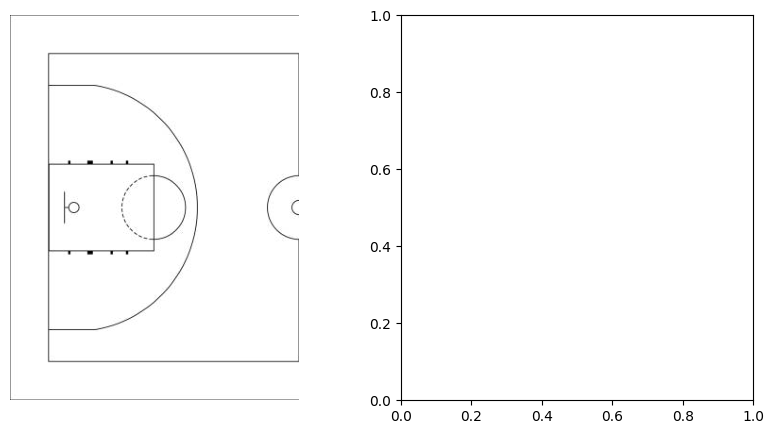

In [493]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display img1 in the first subplot
axes[0].imshow(model, cmap='gray')
axes[0].axis('off')

# Display img2 in the second subplot
axes[1].imshow(match_images_cv2(edges, model), cmap='gray')
axes[1].axis('off')

# Show the plot
plt.show()

### Approach 2: Facebook Detectron2 :)

In [506]:
import torch, detectron2

print("torch: ", torch.__version__)
print("detectron2:", detectron2.__version__)

torch:  2.1.2
detectron2: 0.6


In [507]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [508]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(image)["panoptic_seg"]
v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2.imshow(out.get_image()[:, :, ::-1])

AssertionError: Torch not compiled with CUDA enabled

## Scrapyard

In [3]:
model = YOLO("yolov8n.pt")
results = model(image_path)
results


image 1/1 /Users/aathreyakadambi/Documents/Research/Personal/[PERSONAL:SURYA] LukaVision/code/src/eda/../../data/roboflow/Basketball Players.v22-raw-images-scoreboardclassesonly-nonulls.yolov8/test/images/youtube-0_jpg.rf.0c58f13a69f202f67cb5eef3c9360c92.jpg: 384x640 15 persons, 77.5ms
Speed: 2.4ms preprocess, 77.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

In [4]:
result = results[0]

In [5]:
len(result.boxes)

15

In [6]:
box = result.boxes[0]

In [7]:
print("Object type:", box.cls)
print("Coordinates:", box.xyxy)
print("Probability:", box.conf)

Object type: tensor([0.])
Coordinates: tensor([[ 956.6670,  402.3474, 1108.3457,  680.1383]])
Probability: tensor([0.7608])


In [8]:
for box in result.boxes:
  class_id = result.names[box.cls[0].item()]
  cords = box.xyxy[0].tolist()
  cords = [round(x) for x in cords]
  conf = round(box.conf[0].item(), 2)
  print("Object type:", class_id)
  print("Coordinates:", cords)
  print("Probability:", conf)
  print("---")

Object type: person
Coordinates: [957, 402, 1108, 680]
Probability: 0.76
---
Object type: person
Coordinates: [400, 409, 588, 726]
Probability: 0.75
---
Object type: person
Coordinates: [1558, 351, 1786, 746]
Probability: 0.7
---
Object type: person
Coordinates: [771, 514, 994, 855]
Probability: 0.67
---
Object type: person
Coordinates: [740, 895, 940, 1080]
Probability: 0.64
---
Object type: person
Coordinates: [0, 788, 185, 1076]
Probability: 0.59
---
Object type: person
Coordinates: [1591, 991, 1695, 1080]
Probability: 0.56
---
Object type: person
Coordinates: [931, 828, 1079, 1074]
Probability: 0.51
---
Object type: person
Coordinates: [597, 976, 692, 1080]
Probability: 0.47
---
Object type: person
Coordinates: [361, 860, 523, 1077]
Probability: 0.45
---
Object type: person
Coordinates: [721, 998, 808, 1080]
Probability: 0.45
---
Object type: person
Coordinates: [216, 623, 323, 967]
Probability: 0.44
---
Object type: person
Coordinates: [1220, 638, 1364, 880]
Probability: 0.33
---


In [167]:
image = plt.imread(image_path)

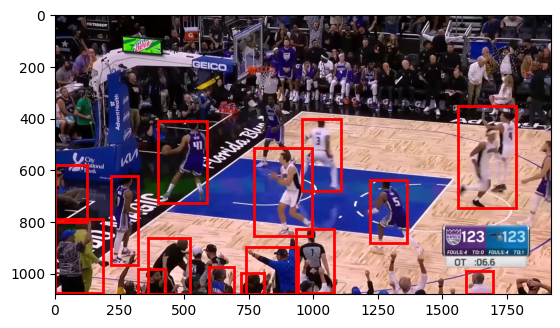

In [10]:
fig, ax = plt.subplots()
ax.imshow(image)
for box in result.boxes:
    ls = box.xyxy[0].tolist()
    rect = patches.Rectangle((ls[0], ls[1]), ls[2]-ls[0], ls[3]-ls[1], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

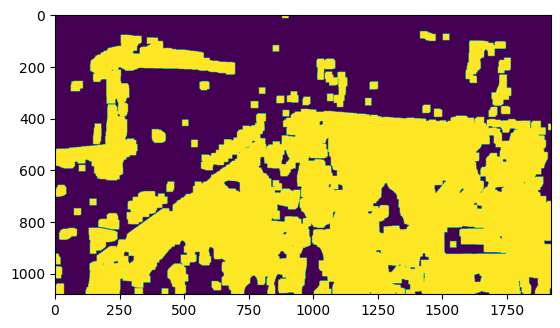

In [335]:
lower = np.uint8([0, 170, 0])
upper = np.uint8([255, 255, 255])
white_mask = cv2.inRange(image, lower, upper)
# yellow color mask
lower = np.uint8([0, 0,   100])
upper = np.uint8([40, 255, 255])
yellow_mask = cv2.inRange(image, lower, upper)
# combine the mask
mask = cv2.bitwise_or(white_mask, yellow_mask)
result = image.copy()

kernel = np.ones((5, 5), np.uint8)
mask = cv2.erode(mask, kernel, iterations=1)  
mask = cv2.dilate(mask, kernel, iterations=6)

plt.imshow(Image.fromarray(mask))

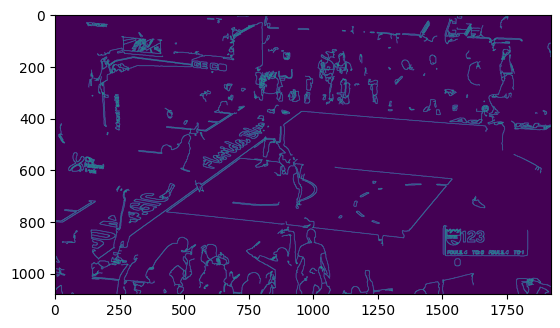

In [215]:
edges = cv2.Canny(image, 800, 100)
plt.imshow(Image.fromarray(edges))

In [51]:
imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [55]:
len(contours)

1892

In [69]:
len(contours[5])

22

In [57]:
len(contours[0][0])

1

In [59]:
contours[0]

array([[[ 690, 1076]],

       [[ 689, 1077]],

       [[ 689, 1079]],

       [[ 713, 1079]],

       [[ 713, 1078]],

       [[ 706, 1078]],

       [[ 705, 1077]],

       [[ 698, 1077]],

       [[ 697, 1076]]], dtype=int32)

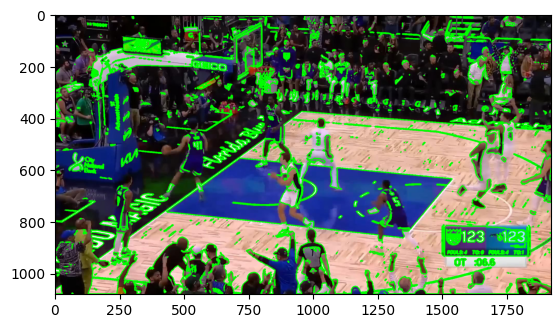

In [54]:
res = cv2.drawContours(image, contours, -1, (0,255,0), 3)
plt.imshow(Image.fromarray(res))

In [75]:
def dist(point1, point2):
    temp = (np.array(point1) - np.array(point2))
    return  temp.dot(temp)

In [164]:
smaller_contours = [ x for x in contours if (len(x) >= 2 and dist(x[0][0], x[-1][0]) > 100) ]

In [165]:
len(smaller_contours)

22

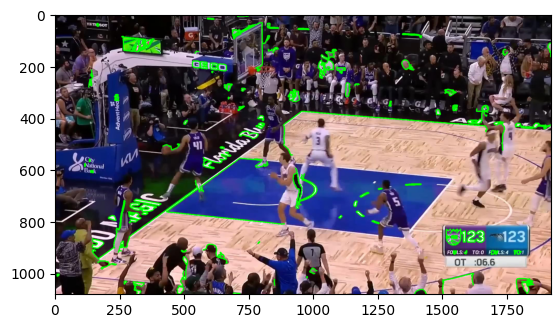

In [166]:
res = cv2.drawContours(image, smaller_contours, -1, (0,255,0), 3)
plt.imshow(Image.fromarray(res))

In [139]:
imgray = edges.copy()
ret, thresh = cv2.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [177]:
smaller_contours = [ x for x in contours if (len(x) >= 2 and dist(x[0][0], x[1][0]) > 50) ]

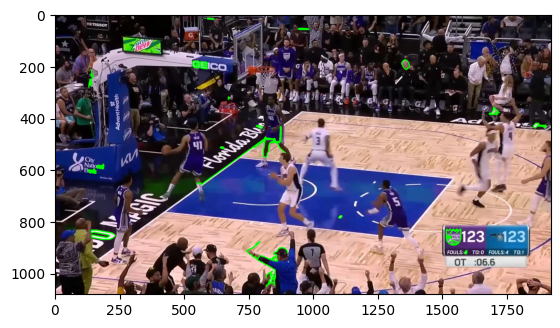

In [178]:
res = cv2.drawContours(image.copy(), smaller_contours, -1, (0,255,0), 3)
plt.imshow(Image.fromarray(res))

In [179]:
imgray = mask.copy()
ret, thresh = cv2.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [182]:
smaller_contours = [ x for x in contours if (len(x) >= 2 and dist(x[0][0], x[1][0]) > 50) ]

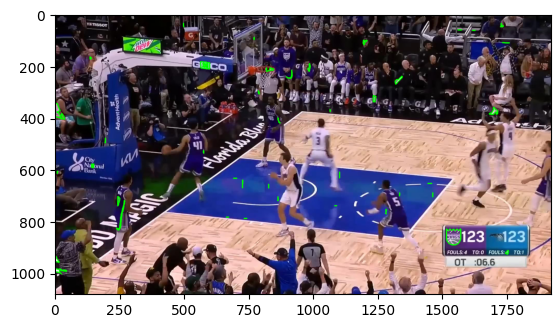

In [183]:
res = cv2.drawContours(image.copy(), smaller_contours, -1, (0,255,0), 3)
plt.imshow(Image.fromarray(res))

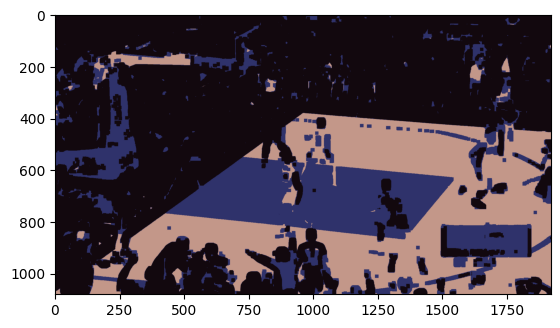

In [502]:
import cv2
import numpy as np

# Kmeans color segmentation
def kmeans_color_quantization(image, clusters=8, rounds=1):
    h, w = image.shape[:2]
    samples = np.zeros([h*w,3], dtype=np.float32)
    count = 0

    for x in range(h):
        for y in range(w):
            samples[count] = image[x][y]
            count += 1

    compactness, labels, centers = cv2.kmeans(samples,
            clusters, 
            None,
            (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, 0.0001), 
            rounds, 
            cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    res = centers[labels.flatten()]
    return res.reshape((image.shape))

# Load image and perform kmeans
image = cv2.erode(image, np.ones((3,3)))
kmeans = kmeans_color_quantization(image, clusters=3)
result = kmeans.copy()

# Floodfill
seed_point = (len(image)/2, len(image[0])/2)
#cv2.floodFill(result, None, seedPoint=seed_point, newVal=(36, 255, 12), loDiff=(0, 0, 0, 0), upDiff=(0, 0, 0, 0))

plt.imshow(Image.fromarray(result))